In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.signal import find_peaks

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')
print(data.shape)
# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

(15, 8465)


![Hubble Image](grb.jpg)

A little bit of data analysis: How many long and short grbs are there? I selected the edge as in the image, at 2 seconds duration.

In [3]:
T90=np.array(data[6],dtype=float)    
long_grb_cond=  (T90>2)
short_grb_cond=  (T90>-999) & (T90<2)
count_long = long_grb_cond.tolist().count(True)
count_short = short_grb_cond.tolist().count(True)
print("number of long GRBs: ", count_long)
print("number of short GRBs: ", count_short)
T90_long = T90[long_grb_cond]
T90_short = T90[short_grb_cond]
durations = np.concatenate((T90_short, T90_long), axis=0).reshape(-1, 1)

number of long GRBs:  6133
number of short GRBs:  1262


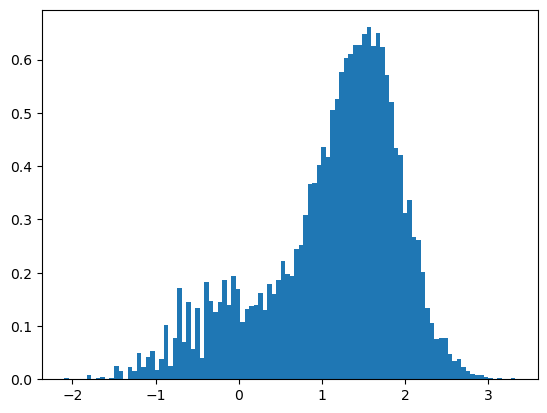

In [4]:
#Does the distribution contain different sub-populations? How many?
condition=T90>-999
logmin=np.log10(min(T90[condition]))
logmax=np.log10(max(T90[condition]))
plt.hist(np.log10(T90[condition]), bins=100, density=True);


In [5]:
X=np.log10(T90[condition])[:, np.newaxis]

In [6]:
clf = KMeans(n_clusters=2,n_init='auto', random_state=30) 
clf.fit(X)
centers = np.squeeze(clf.cluster_centers_) #location of the clusters
#centers = 10**(np.squeeze(centers))
print("Centers of the two groups:", centers)
labels = clf.predict(X) #labels for each of the points
print("number elements first group: ", labels.tolist().count(0))
print("number of elements second group: ", labels.tolist().count(1))

Centers of the two groups: [ 1.516679   -0.05740888]
number elements first group:  5538
number of elements second group:  1863


In [7]:
edge = 10**( np.mean( [max(X[labels==0]), min(X[labels==1]) ]))
print("Edge between the two groups: ", edge)

Edge between the two groups:  4.09878030638384


I found that the clustering with K-Means divided the groups at $\sim$ 4 seconds and not at 2 as proposed by literature.

In [8]:
#let's try to use kde
def kde_sklearn(data, bandwidth = 0.1):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

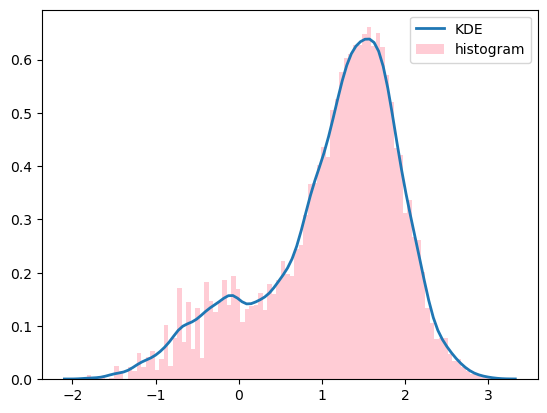

In [9]:
xgrid =np.linspace(logmin ,logmax , 100)
pdf = kde_sklearn(np.log10(T90[condition]),bandwidth=0.1)
plt.plot(xgrid,pdf, label='KDE', lw=2)
plt.hist(np.log10(T90[condition]), bins=100, color='pink',density=True, alpha=0.8, label='histogram' );
plt.legend()

[0.01       0.03538462 0.06076923 0.08615385 0.11153846 0.13692308
 0.16230769 0.18769231 0.21307692 0.23846154 0.26384615 0.28923077
 0.31461538 0.34       0.36538462 0.39076923 0.41615385 0.44153846
 0.46692308 0.49230769 0.51769231 0.54307692 0.56846154 0.59384615
 0.61923077 0.64461538 0.67       0.69538462 0.72076923 0.74615385
 0.77153846 0.79692308 0.82230769 0.84769231 0.87307692 0.89846154
 0.92384615 0.94923077 0.97461538 1.        ]
0.11153846153846153


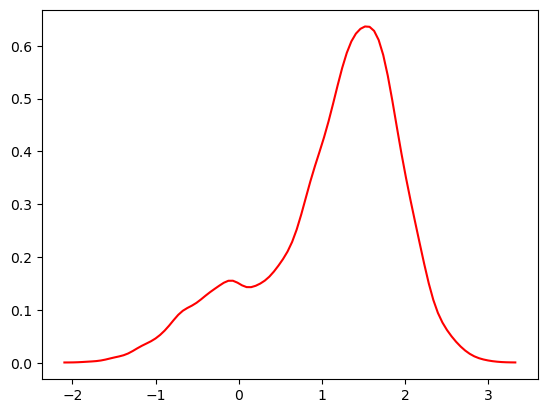

In [10]:
#ATTENTION!! IT TAKES A WHILE TO RUN
# bw research (to be sure of what i put before)
bwrange = np.linspace(0.01,1.0, 40) # Test 30 bandwidths from 0.01 to 1.0
print(bwrange)
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(np.log10(T90[condition])[:, None]) 
h_opt = grid.best_params_['bandwidth']
print(h_opt) #0.11153846153846153
pdf = kde_sklearn(np.log10(T90[condition]),bandwidth=h_opt)
plt.plot(xgrid,pdf,c='red')

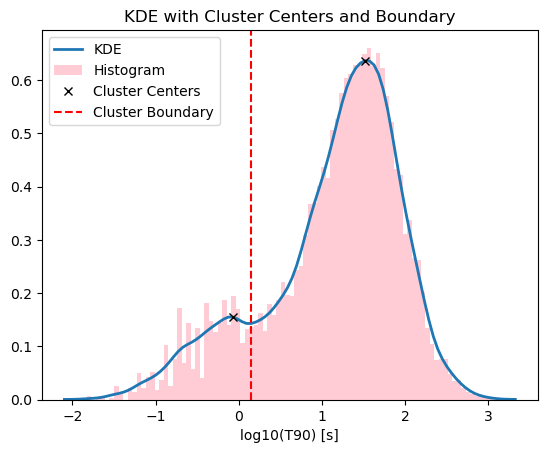

Cluster centers: [-0.07157886  1.51584286]
Cluster boundary: 0.1473758619153882
Cluster boundary in seconds:  1.4040283008675338


In [11]:

# Find peaks in the KDE
peaks, _ = find_peaks(pdf)

# Plotting

0
plt.plot(xgrid, pdf, label='KDE', lw=2)
plt.hist(np.log10(T90[condition]), bins=100, color='pink', density=True, alpha=0.8, label='Histogram')
plt.plot(xgrid[peaks], pdf[peaks],  "x",color='black', label='Cluster Centers')

#Here the code returns the index of the minimum value in the slice of the pdf in the segment of the density estimate between the first and the second peak. 
#Essentially, it finds the point of lowest density between the two peaks
if len(peaks) > 1:
    min_idx = np.argmin(pdf[peaks[0]:peaks[1]]) + peaks[0]
    plt.axvline(xgrid[min_idx], color='red', linestyle='--', label='Cluster Boundary')

plt.legend()
plt.xlabel('log10(T90) [s]')
plt.title('KDE with Cluster Centers and Boundary')
plt.show()

# Output the center of the clusters
cluster_centers = xgrid[peaks]
print(f"Cluster centers: {cluster_centers}")

# Output the edge between the clusters
if len(peaks) > 1:
    cluster_boundary = xgrid[min_idx]
    print(f"Cluster boundary: {cluster_boundary}")
    print("Cluster boundary in seconds: ", 10**(cluster_boundary))

Using KDE the edge is nearer to the real one of 2 seconds reported in literature. KDE is a valid method for the identification of clusters and their boundaries especially with complex distributions or with not perfectly Gaussian data as in this case. Anyway below there is a comparison with a Gaussian Mixture method.

**GAUSSIAN MIXTURE EVALUATION**

In [12]:
components_range = range(1,10)

gm_models = []
for n_components in components_range:
    gm = GaussianMixture(n_components=n_components, random_state=30)
    gm.fit(X)
    gm_models.append(gm)

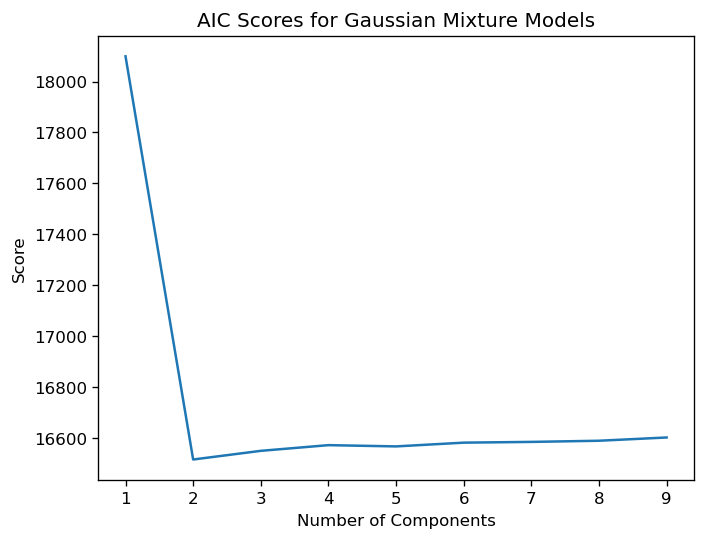

In [13]:
plt.figure(dpi = 120)    
plt.plot(components_range, [model.aic(X) for model in gm_models], label='AIC') 
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('AIC Scores for Gaussian Mixture Models')
plt.show()

The model with lowest AIC is the most favored: as already shown there are indeed 2 components (groups) in this dataset

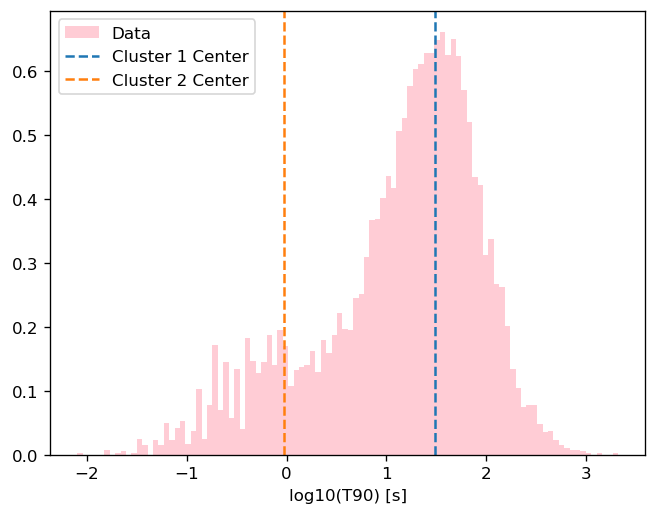

Cluster 1:
  Mean: 1.487
  Variance: 0.213
  Weight: 0.759
Cluster 2:
  Mean: -0.031
  Variance: 0.381
  Weight: 0.241


In [14]:
# Fit the best model (choose based on AIC)
optimal_gm = gm_models[np.argmin([model.aic(X) for model in gm_models])]
labels_gm = optimal_gm.predict(X)
centers_gm = optimal_gm.means_.flatten()

plt.figure(dpi=120)
plt.hist(X, bins=100, alpha=0.8, label='Data', color='pink', density=True)
for i in range(len(centers_gm)):
    plt.axvline(centers_gm[i], color=f'C{i}', linestyle='--', label=f'Cluster {i+1} Center')

plt.xlabel('log10(T90) [s]')
plt.legend()
plt.show()

#log scale properties
for i in range(optimal_gm.n_components):
    print(f"Cluster {i+1}:")
    print(f"  Mean: {optimal_gm.means_[i][0]:.3f}")
    print(f"  Variance: {optimal_gm.covariances_[i][0][0]:.3f}")
    print(f"  Weight: {optimal_gm.weights_[i]:.3f}")

In [15]:
#in seconds
for i in range(optimal_gm.n_components):
    mean = 10**(optimal_gm.means_[i][0])
    variance = 10**(optimal_gm.covariances_[i][0][0])
    print(f"Cluster {i+1}:")
    print(f"  Mean (in seconds): {mean:.3f}")
    print(f"  Variance (in seconds): {variance:.3f}")
    print(f"  Weight: {optimal_gm.weights_[i]:.3f}")

Cluster 1:
  Mean (in seconds): 30.685
  Variance (in seconds): 1.633
  Weight: 0.759
Cluster 2:
  Mean (in seconds): 0.932
  Variance (in seconds): 2.405
  Weight: 0.241


In [16]:
edge_gm = 10**( np.mean( [max(X[labels_gm==0]), min(X[labels_gm==1]) ]))
print("Edge between the two groups: ", edge_gm)

Edge between the two groups:  4.09878030638384


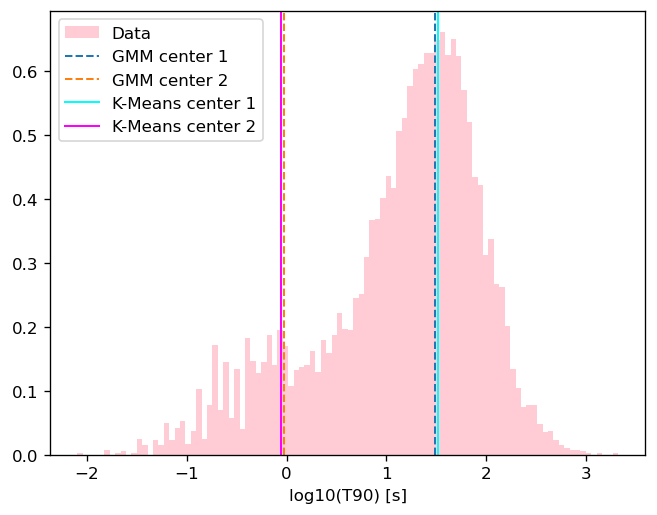

In [17]:
plt.figure(dpi=120)
plt.hist(X, bins=100, alpha=0.8, label='Data', color='pink', density=True)
for i in range(len(centers_gm)):
    plt.axvline(centers_gm[i], color=f'C{i}', linestyle='--', label=f'GMM center {i+1}', lw=1.2)
colors_kmean = ['cyan', 'magenta']
for i in range(len(centers)):
    color_kmean = colors_kmean[i % len(colors_kmean)]
    plt.axvline(centers[i], color=color_kmean, label=f'K-Means center {i+1}', lw=1.2)
plt.xlabel('log10(T90) [s]')
plt.legend()
plt.show()

343


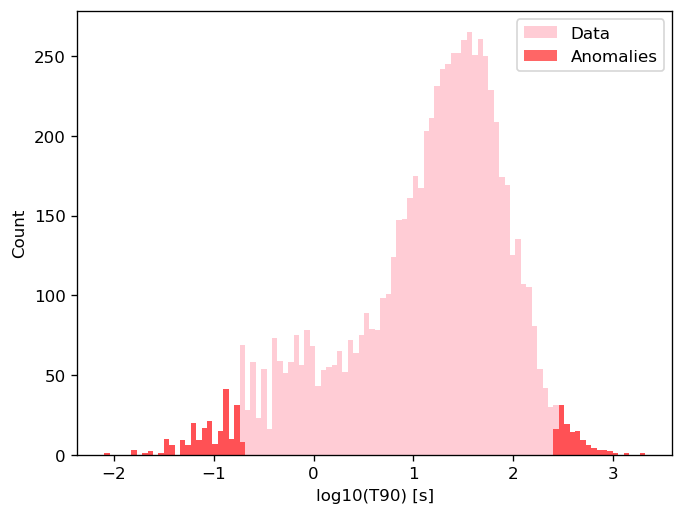

In [18]:
# Calculate the log likelihood of each data point
log_likelihood = optimal_gm.score_samples(X)
threshold = np.percentile(log_likelihood, 5)  # tail 5% as anomalies or outliers
anomalies = X[log_likelihood < threshold]
print(len(anomalies))

# Plot anomalies
plt.figure(dpi=120)
plt.hist(X, bins=100, alpha=0.8, color='pink', label='Data')
plt.hist(anomalies, bins=100, alpha=0.6, label='Anomalies', color='red')
plt.xlabel('log10(T90) [s]')
plt.ylabel('Count')
plt.legend()
plt.show()


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


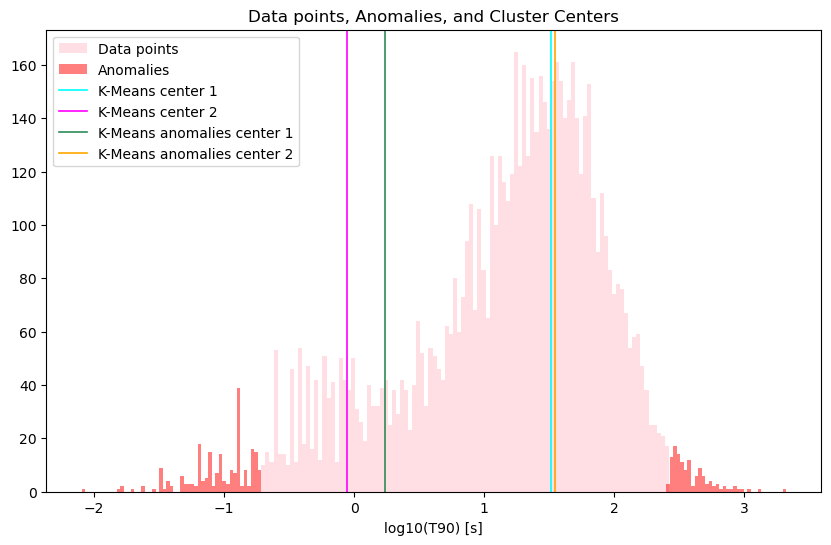

In [19]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X[log_likelihood > threshold])
centers2 = np.squeeze(kmeans.cluster_centers_)
# Plotting
plt.figure(figsize=(10, 6))

plt.hist(X[log_likelihood > threshold], color='pink',bins=100, label='Data points', alpha=0.5)

plt.hist(anomalies, color='red', bins=200, label='Anomalies', alpha=0.5)

for i in range(len(centers)):
    color_kmean = colors_kmean[i % len(colors_kmean)]
    plt.axvline(centers[i], color=color_kmean, label=f'K-Means center {i+1}', lw=1.2)
colors_kmean2 = ['seagreen', 'orange']
for i in range(len(centers2)):
    color_kmean2 = colors_kmean2[i % len(colors_kmean2)]
    plt.axvline(centers2[i], color=color_kmean2, label=f'K-Means anomalies center {i+1}', lw=1.2)
plt.xlabel('log10(T90) [s]')
plt.title('Data points, Anomalies, and Cluster Centers')
plt.legend()
plt.show()

In [20]:
X2=X[log_likelihood > threshold]
labels2 = kmeans.predict(X2) 
edge2 = 10**( np.mean( [max(X2[labels2==0]), min(X2[labels2==1]) ]))
print("Edge between the two groups: ", edge2)

Edge between the two groups:  7.775934156099831


Even if I excluded anomalies from the computation, the edge is not representing the literature one of 2 seconds. 

**Individual GMM components**

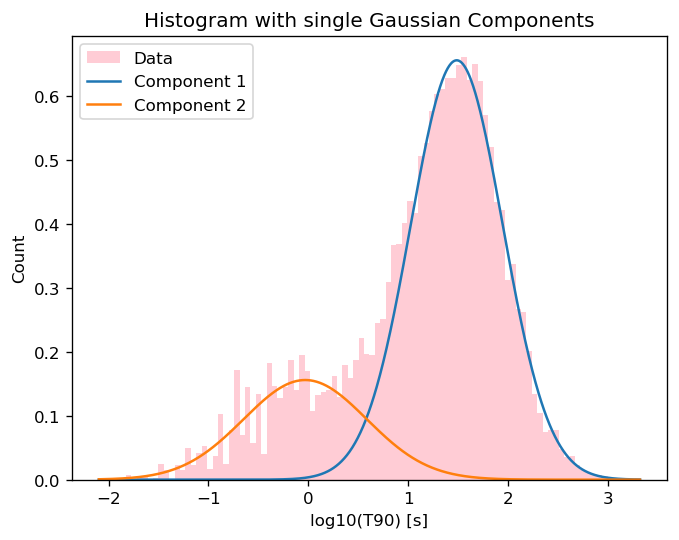

In [21]:
# Plotting histograms with individual GMM components
plt.figure(dpi=120)

# Plot overall data histogram
plt.hist(X, bins=100, alpha=0.8, color='pink', label='Data', density=True)

# Plot individual Gaussian components
x = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
responsiblity = optimal_gm.predict_proba(x.reshape(-1, 1))
logprob = optimal_gm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
for i in range(responsiblity.shape[1]):
   
    # Calculate PDF for each Gaussian component
    pdf_values =responsiblity[:,i] * pdf

    plt.plot(x, pdf_values, label=f'Component {i+1}')

plt.xlabel('log10(T90) [s]')
plt.ylabel('Count')
plt.legend()
plt.title('Histogram with single Gaussian Components')
plt.show()

**Silhouette Score**: This metric measures how similar each point is to its own cluster compared to other clusters. A higher silhouette score indicates better-defined clusters. It is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) (i.e. distance between a sample and the nearest cluster that the sample is not a part of) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). Best value = 1

In [22]:
labels = optimal_gm.predict(X)
silhouette_score_value = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_score_value}")

Silhouette Score: 0.6499713881640702


The score is not so low, but as it can be seen in the individual gaussian components plot, the overlapping is not negligible, so it influences the clustering efficiency. 